In [1]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, hinge_loss
import seaborn as sns
from sklearn.model_selection import  StratifiedKFold
from sklearn.preprocessing import LabelBinarizer

seed = 42
np.random.seed(seed)

## Task 1: MCI vs. AD

In [2]:
train_data = pd.read_csv('train_mi_data.csv', index_col=None)

# Separate features (genes) and labels
X = train_data.drop(columns=['sample', 'disease_state'])
label_map = {
    'S-MCI': 'MCI',
    'P-MCI': 'MCI',
    'AD':'AD'
}
y = train_data['disease_state'].map(label_map)
print(f"Classify:  {np.unique(y, return_counts=True)} clases")

Classify:  (array(['AD', 'MCI'], dtype=object), array([49, 67])) clases


Best C found by nested CV = 10
Evaluating LOOCV metrics for top 10 genes...
acc: 0.7931034482758621, loss: 0.582303434963346, specificity: 0.7910447761194029, sensitivity: 0.7910447761194029
Evaluating LOOCV metrics for top 20 genes...
acc: 0.8103448275862069, loss: 0.6192402617970502, specificity: 0.835820895522388, sensitivity: 0.835820895522388
Evaluating LOOCV metrics for top 30 genes...
acc: 0.8879310344827587, loss: 0.44440623657466477, specificity: 0.9253731343283582, sensitivity: 0.9253731343283582
Evaluating LOOCV metrics for top 40 genes...
acc: 0.8793103448275862, loss: 0.37717959133428225, specificity: 0.8955223880597015, sensitivity: 0.8955223880597015
Evaluating LOOCV metrics for top 50 genes...
acc: 0.9482758620689655, loss: 0.18856415507356888, specificity: 0.9402985074626866, sensitivity: 0.9402985074626866
Evaluating LOOCV metrics for top 60 genes...
acc: 0.9482758620689655, loss: 0.142358181125896, specificity: 0.9552238805970149, sensitivity: 0.9552238805970149
Eval

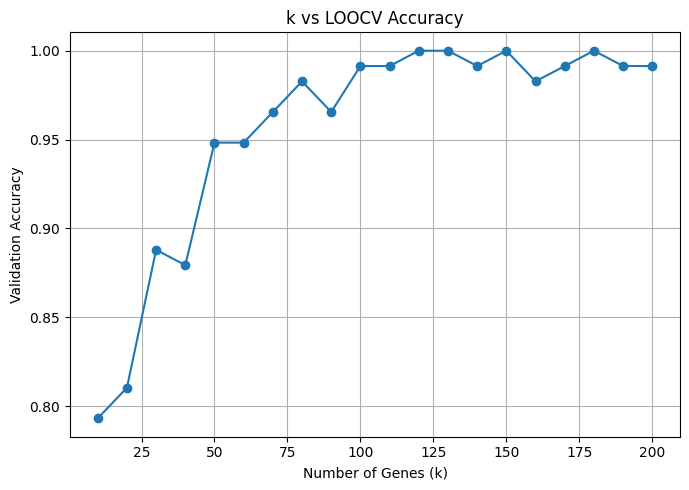


Final model trained using top 120 genes.
acc: 1.0, specificity: 1.0, sensitivity: 1.0


In [4]:
def compute_metrics(y_true, y_pred, decision_values=None):
    acc = accuracy_score(y_true, y_pred)
    sens = recall_score(y_true, y_pred, pos_label='MCI', zero_division=0)
    spec = recall_score(y_true, y_pred, pos_label='MCI', zero_division=0)
    
    # Convert string labels to 0/1 for hinge loss
    if decision_values is not None:
        lb = LabelBinarizer(pos_label=1, neg_label=-1)  # -1/1 for hinge_loss
        y_true_bin = lb.fit_transform(y_true).flatten()
        loss = hinge_loss(y_true_bin, decision_values)
    else:
        loss = None
        
    return acc, sens, spec, loss

# Candidate C values for nested CV
param_grid = {"lr__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

nested_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
            penalty="l2",
            max_iter=5000,
            class_weight="balanced",
            random_state=seed
        ))
])

grid = GridSearchCV(
    nested_pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X, y)

best_C = grid.best_params_["lr__C"]
print("Best C found by nested CV =", best_C)

# Train final model on entire dataset with best C
rank_model = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("lr", LogisticRegression(
            C=best_C,
            penalty="l2",
            max_iter=5000,
            class_weight="balanced",
            random_state=seed
        ))
])

rank_model.fit(X, y)

coef = np.abs(rank_model.named_steps["lr"].coef_[0])

gene_importance = pd.DataFrame({
    "gene": X.columns,
    "importance": coef
}).sort_values("importance", ascending=False)

ranked_genes = gene_importance["gene"].tolist()

# Leave-One-Out Cross-Validation for varying k
def loocv_metrics(X_sub, y, C_value):
    loo = LeaveOneOut()
    y_true_all = []
    y_pred_all = []
    decision_values_all = []

    for train_idx, test_idx in loo.split(X_sub):
        X_train, X_test = X_sub.iloc[train_idx], X_sub.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(
                C=best_C,
                penalty="l2",
                max_iter=5000,
                class_weight="balanced",
                random_state=seed
            ))
        ])
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_true_all.append(y_test.iloc[0])
        y_pred_all.append(y_pred[0])
        decision_values_all.append(model.decision_function(X_test)[0])

    acc, sens, spec, loss =  compute_metrics(
        pd.Series(y_true_all),
        pd.Series(y_pred_all),
        np.array(decision_values_all)
    )
    return { "val_acc": np.mean(acc), "val_sens": np.mean(sens), "val_spec": np.mean(spec), "val_loss": np.mean(loss) }


k_values = list(range(10, 201, 10))
results = []
for k in k_values:
    selected_genes = ranked_genes[:k]
    X_k = X[selected_genes]

    print(f"Evaluating LOOCV metrics for top {k} genes...")

    metrics_k = loocv_metrics(X_k, y, C_value=best_C)
    metrics_k["k"] = k
    results.append(metrics_k)
    print(f"acc: {metrics_k['val_acc']}, loss: {metrics_k['val_loss']}, specificity: {metrics_k['val_spec']}, sensitivity: {metrics_k['val_sens']}")

result_df = pd.DataFrame(results)
# Select best k by validation accuracy
best_row = result_df.loc[result_df["val_acc"].idxmax()]
best_k = int(best_row["k"])
print("\nOptimal k =", best_k)
print("Best validation accuracy =", best_row["val_acc"])
plt.figure(figsize=(7,5))
plt.plot(result_df["k"], result_df["val_acc"], marker="o")
plt.title("k vs LOOCV Accuracy")
plt.xlabel("Number of Genes (k)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


# Train final model with optimal k
optimal_genes = ranked_genes[:best_k]
X_optimal = X[optimal_genes]
print("\nFinal model trained using top", best_k, "genes.")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []
coef_matrix = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_optimal, y), start=1):
    X_train_fold = X_optimal.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold   = X_optimal.iloc[val_idx]
    y_val_fold   = y.iloc[val_idx]

    final_model_task1 = Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            ("lr", LogisticRegression(
                C=best_C,
                penalty="l2",
                max_iter=5000,
                class_weight="balanced",
                random_state=seed
            ))
    ])
    final_model_task1.fit(X_train_fold, y_train_fold)
    y_pred_fold = final_model_task1.predict(X_val_fold)

    y_true_all.extend(y_val_fold.tolist())
    y_pred_all.extend(y_pred_fold.tolist())
    coef_matrix.append(final_model_task1.named_steps["lr"].coef_[0])

acc = accuracy_score(y_true_all, y_pred_all)
sens = recall_score(y_true_all, y_pred_all, pos_label='MCI', zero_division=0)
spec = recall_score(y_true_all, y_pred_all, pos_label='MCI', zero_division=0)
cm = confusion_matrix(y_true_all, y_pred_all)
print(f"acc: {acc}, specificity: {spec}, sensitivity: {sens}")

# Save gene set
coef_matrix = np.array(coef_matrix)
mean_coef = np.mean(np.abs(coef_matrix), axis=0)
importance_df = pd.DataFrame({
    "gene": optimal_genes,
    "importance_score": mean_coef
}).sort_values("importance_score", ascending=False)
importance_df.to_csv("top_lr_task1.csv", index=False)


Classify:  (array(['AD', 'MCI'], dtype=object), array([21, 20])) clases
Test shape: (41, 120)

Test Set Metrics:
Accuracy: 0.5610
Sensitivity: 0.1500
Specificity: 0.1500
Loss: 150.0180


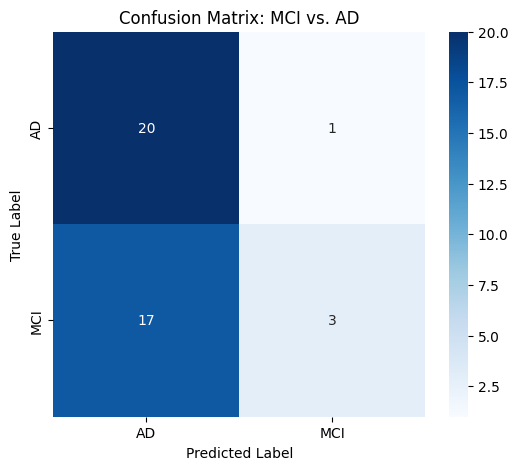

In [5]:
# Evaluation
test_df = pd.read_csv('test_mi_data.csv')  

X_test = test_df.drop(columns=['disease_state'])
y_test = test_df['disease_state']
print(f"Classify:  {np.unique(y_test, return_counts=True)} clases")

X_test_optimal = X_test[optimal_genes]
print(f"Test shape: {X_test_optimal.shape}")

# Predictions
y_pred_test = final_model_task1.predict(X_test_optimal)

# Decision scores for hinge loss
decision_vals = final_model_task1.decision_function(X_test_optimal)

# Metrics
acc_test, sens_test, spec_test, loss_test = compute_metrics(
    y_test, y_pred_test, decision_vals
)

print(f"\nTest Set Metrics:")
print(f"Accuracy: {acc_test:.4f}")
print(f"Sensitivity: {sens_test:.4f}")
print(f"Specificity: {spec_test:.4f}")
print(f"Loss: {loss_test:.4f}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['AD', 'MCI'],
            yticklabels=['AD', 'MCI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MCI vs. AD')
plt.show()

## Task 2: S-MCI vs P-MCI vs AD

In [7]:
train_data = pd.read_csv('train_mi_data.csv', index_col=None)
X = train_data.drop(columns=['sample', 'disease_state'])
y = train_data['disease_state']
print(f"Classify:  {np.unique(y, return_counts=True)} clases")
classes = ['S-MCI', 'P-MCI', 'AD']

Classify:  (array(['AD', 'P-MCI', 'S-MCI'], dtype=object), array([49, 28, 39])) clases


/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/linear_model/_logistic

Best C found by nested CV = 10
Evaluating LOOCV metrics for top 10 genes...


/opt/anaconda3/envs/ai/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


acc: 0.543, specificity: {'S-MCI': 0.7662337662337663, 'P-MCI': 0.7386363636363636, 'AD': 0.8208955223880597}, sensitivity: {'S-MCI': 0.2564102564102564, 'P-MCI': 0.5, 'AD': 0.7959183673469388}
Evaluating LOOCV metrics for top 20 genes...
acc: 0.560, specificity: {'S-MCI': 0.6883116883116883, 'P-MCI': 0.8068181818181818, 'AD': 0.8507462686567164}, sensitivity: {'S-MCI': 0.4358974358974359, 'P-MCI': 0.39285714285714285, 'AD': 0.7551020408163265}
Evaluating LOOCV metrics for top 30 genes...
acc: 0.638, specificity: {'S-MCI': 0.7012987012987013, 'P-MCI': 0.8181818181818182, 'AD': 0.9552238805970149}, sensitivity: {'S-MCI': 0.5128205128205128, 'P-MCI': 0.4642857142857143, 'AD': 0.8367346938775511}
Evaluating LOOCV metrics for top 40 genes...
acc: 0.586, specificity: {'S-MCI': 0.7142857142857143, 'P-MCI': 0.7727272727272727, 'AD': 0.9104477611940298}, sensitivity: {'S-MCI': 0.48717948717948717, 'P-MCI': 0.39285714285714285, 'AD': 0.7755102040816326}
Evaluating LOOCV metrics for top 50 genes

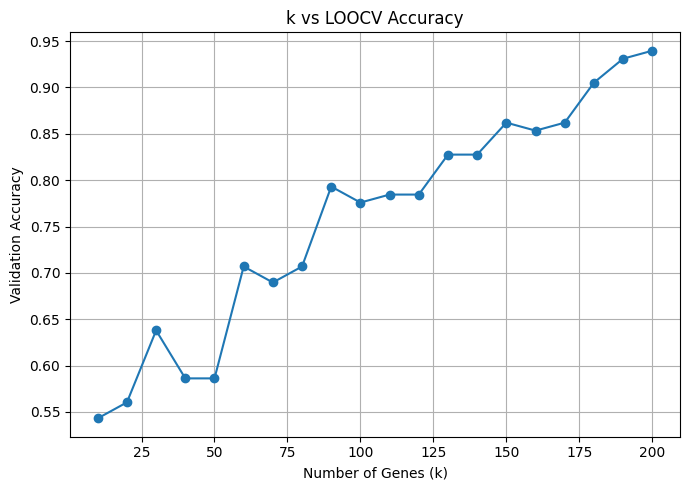


Final model trained using top 200 genes.
acc: 0.922, specificity: {'S-MCI': 0.922077922077922, 'P-MCI': 0.9659090909090909, 'AD': 1.0}, sensitivity: {'S-MCI': 0.9230769230769231, 'P-MCI': 0.8214285714285714, 'AD': 0.9795918367346939}


In [10]:
def compute_metrics(y_true, y_pred, classes):
    """
    Returns overall accuracy, per-class sensitivity and specificity
    as dictionaries/matrix.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    acc = accuracy_score(y_true, y_pred)

    sens = {}  # sensitivity / recall per class
    spec = {}  # specificity per class

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens[cls] = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec[cls] = TN / (TN + FP) if (TN + FP) > 0 else 0

    return acc, sens, spec, cm


# Candidate C values for nested CV
param_grid = {"lr__C": [0.0001, 0.001, 0.01, 0.1, 1, 10]}

nested_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    (("lr", LogisticRegression(
            penalty="l2",
            max_iter=5000,
            class_weight="balanced",
            random_state=seed,
            multi_class='ovr'
        )))
])

grid = GridSearchCV(
    nested_pipeline,
    param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X, y)

best_C = grid.best_params_["lr__C"]
print("Best C found by nested CV =", best_C)

# Train final model on entire dataset with best C
rank_model = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    (("lr", LogisticRegression(
            C=best_C,
            penalty="l2",
            max_iter=5000,
            class_weight="balanced",
            random_state=seed,
            multi_class='ovr'
        )))
])

rank_model.fit(X, y)

coef = np.abs(rank_model.named_steps["lr"].coef_[0])

gene_importance = pd.DataFrame({
    "gene": X.columns,
    "importance": coef
}).sort_values("importance", ascending=False)

ranked_genes = gene_importance["gene"].tolist()

# Leave-One-Out Cross-Validation for varying k
def loocv_metrics(X_sub, y, C_value):
    loo = LeaveOneOut()
    y_true_all = []
    y_pred_all = []
    decision_values_all = []

    for train_idx, test_idx in loo.split(X_sub):
        X_train, X_test = X_sub.iloc[train_idx], X_sub.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            (("lr", LogisticRegression(
                C=best_C,
                penalty="l2",
                max_iter=5000,
                class_weight="balanced",
                random_state=seed
            )))
        ])
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_true_all.append(y_test.iloc[0])
        y_pred_all.append(y_pred[0])
        decision_values_all.append(model.decision_function(X_test)[0])

    acc, sens, spec, cm =  compute_metrics(
        pd.Series(y_true_all),
        pd.Series(y_pred_all),
        classes
    )
    return { "val_acc": np.mean(acc), "val_sens": sens, "val_spec": spec}


k_values = list(range(10, 201, 10))
results = []
for k in k_values:
    selected_genes = ranked_genes[:k]
    X_k = X[selected_genes]

    print(f"Evaluating LOOCV metrics for top {k} genes...")

    metrics_k = loocv_metrics(X_k, y, C_value=best_C)
    metrics_k["k"] = k
    results.append(metrics_k)
    print(f"acc: {metrics_k['val_acc']:.3f}, specificity: {metrics_k['val_spec']}, sensitivity: {metrics_k['val_sens']}")

result_df = pd.DataFrame(results)
# Select best k by validation accuracy
best_row = result_df.loc[result_df["val_acc"].idxmax()]
best_k = int(best_row["k"])
print("\nOptimal k =", best_k)
print("Best validation accuracy =", best_row["val_acc"])
plt.figure(figsize=(7,5))
plt.plot(result_df["k"], result_df["val_acc"], marker="o")
plt.title("k vs LOOCV Accuracy")
plt.xlabel("Number of Genes (k)")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.tight_layout()
plt.show()


# Train final model with optimal k
optimal_genes = ranked_genes[:best_k]
X_optimal = X[optimal_genes]
print("\nFinal model trained using top", best_k, "genes.")

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y_true_all = []
y_pred_all = []
coef_matrix = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_optimal, y), start=1):
    X_train_fold = X_optimal.iloc[train_idx]
    y_train_fold = y.iloc[train_idx]
    X_val_fold   = X_optimal.iloc[val_idx]
    y_val_fold   = y.iloc[val_idx]

    final_model_task2 = Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler()),
            (("lr", LogisticRegression(
                C=best_C,
                penalty="l2",
                max_iter=5000,
                class_weight="balanced",
                random_state=seed
            )))
    ])
    final_model_task2.fit(X_train_fold, y_train_fold)
    y_pred_fold = final_model_task2.predict(X_val_fold)

    y_true_all.extend(y_val_fold.tolist())
    y_pred_all.extend(y_pred_fold.tolist())
    coef_matrix.append(final_model_task2.named_steps["lr"].coef_[0])

acc, sens, spec, cm = compute_metrics(y_true_all, y_pred_all, classes)
# sens_values = np.array(list(sens.values())).mean()
# spec_values = np.array(list(spec.values())).mean()

print(f"acc: {acc:.3f}, specificity: {spec}, sensitivity: {sens}")

# Save gene set
coef_matrix = np.array(coef_matrix)
mean_coef = np.mean(np.abs(coef_matrix), axis=0)
importance_df = pd.DataFrame({
    "gene": optimal_genes,
    "importance_score": mean_coef
}).sort_values("importance_score", ascending=False)
importance_df.to_csv("top_lr_task2.csv", index=False)

Classify:  (array(['AD', 'MCI'], dtype=object), array([21, 20])) clases
Test shape: (41, 200)
Prediction class: (array(['AD', 'MCI'], dtype='<U3'), array([38,  3]))

Test Set Metrics:
Accuracy: 0.5366
Sensitivity: {'AD': 0.9523809523809523, 'MCI': 0.1}
Specificity: {'AD': 0.1, 'MCI': 0.9523809523809523}


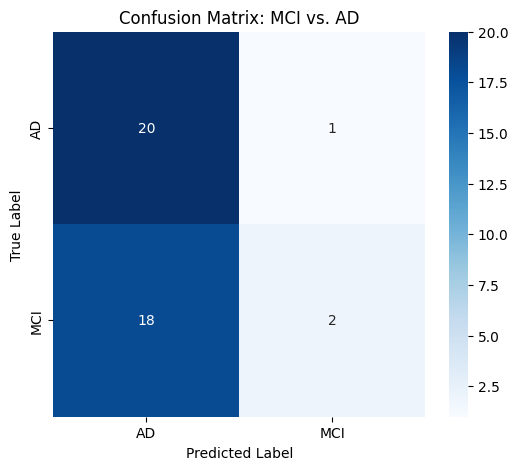

In [11]:
# Evaluation
test_df = pd.read_csv('test_mi_data.csv')  

X_test = test_df.drop(columns=['disease_state'])
y_test = test_df['disease_state']
print(f"Classify:  {np.unique(y_test, return_counts=True)} clases")

X_test_optimal = X_test[optimal_genes]
print(f"Test shape: {X_test_optimal.shape}")

# Predictions
y_pred_test = final_model_task2.predict(X_test_optimal)
label_map = {'S-MCI':'MCI', 'P-MCI':'MCI','AD':'AD'}
y_pred_test_mapped = np.array([label_map[label] for label in y_pred_test])
print(f"Prediction class: {np.unique(y_pred_test_mapped, return_counts=True)}")

# Metrics
acc, sens, spec, cm = compute_metrics(
    y_test, y_pred_test_mapped, ['AD', 'MCI']
)

print(f"\nTest Set Metrics:")
print(f"Accuracy: {acc:.4f}")
print(f"Sensitivity: {sens}")
print(f"Specificity: {spec}")

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['AD', 'MCI'],
            yticklabels=['AD', 'MCI'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MCI vs. AD')
plt.show()

## Merge with gene symbol

In [12]:
gene_symbol = pd.read_csv('gene_id_and_gene_symbols.csv')

# task 1
top_gene_task1 = pd.read_csv('top_lr_task1.csv')
task1_merge = top_gene_task1.merge(gene_symbol, on='gene_id', how='left')

task1_ranked_df = pd.DataFrame({
    "gene": task1_merge['gene_symbol'],
    "score": task1_merge['importance_score']
})
task1_ranked_df.head(5)
task1_ranked_df.to_csv("lr_ranked_task1.rnk", sep="\t", header=False, index=False) # Save to file required by GSEA

# task 2
top_gene_task2 = pd.read_csv('top_lr_task2.csv')
task2_merge = top_gene_task2.merge(gene_symbol, on='gene_id', how='left')

task2_ranked_df = pd.DataFrame({
    "gene": task2_merge['gene_symbol'],
    "score": task2_merge['importance_score']
})
task2_ranked_df.head(5)
task2_ranked_df.to_csv("lr_ranked_task2.rnk", sep="\t", header=False, index=False) # Save to file required by GSEA

## GSEA

2025-12-08 19:08:27,521 [INFO] Parsing data files for GSEA.............................
2025-12-08 19:08:27,522 [INFO] Enrichr library gene sets already downloaded in: /Users/kitiya/.cache/gseapy, use local file
2025-12-08 19:08:27,529 [INFO] 0298 gene_sets have been filtered out when max_size=100 and min_size=2
2025-12-08 19:08:27,530 [INFO] 0022 gene_sets used for further statistical testing.....
2025-12-08 19:08:27,530 [INFO] Start to run GSEA...Might take a while..................
2025-12-08 19:08:27,530 [INFO] Genes are converted to uppercase.
2025-12-08 19:08:28,177 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Osteoclast differentiation,-0.915254,-1.551257,0.032419,0.082108,0.145291,2/2,10.83%,PPARG;CTSK
1,prerank,Pathogenic Escherichia coli infection,0.889831,1.502744,0.023529,0.529549,0.224,2/2,12.50%,CASP7;MYO1H
2,prerank,DNA replication,-0.813559,-1.385929,0.109859,0.15264,0.417836,2/2,20.83%,POLE2;DNA2
3,prerank,Ubiquitin mediated proteolysis,0.734087,1.246259,0.159468,1.0,0.772,1/2,2.50%,UBE2QL1
4,prerank,Non-alcoholic fatty liver disease,0.739644,1.242826,0.156146,0.786006,0.778,1/2,11.67%,CASP7


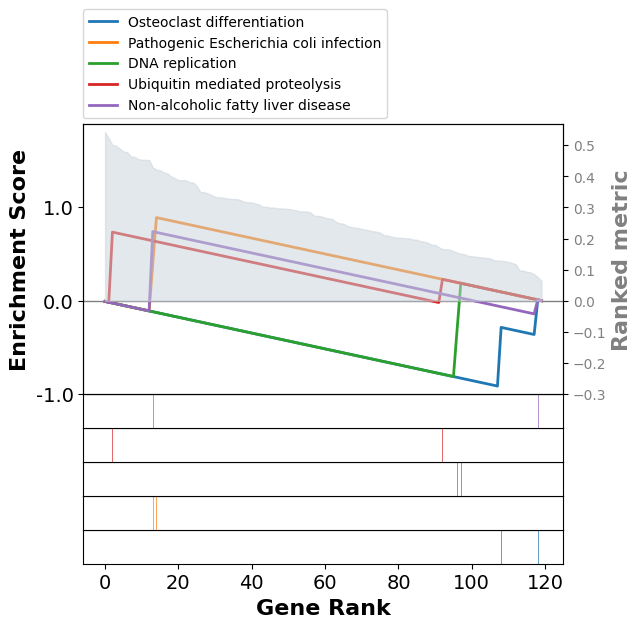

In [13]:
import gseapy as gp

# Run prerank GSEA
pre_res = gp.prerank(
    rnk="lr_ranked_task1.rnk",
    gene_sets='KEGG_2021_Human', 
    outdir='gsea_results',
    min_size=2,
    max_size=100,
    permutation_num=1000,
    seed=6,
    verbose=True
)

# Display top enriched pathways
display(pre_res.res2d.head(5))

# Plot GSEA enrichment for top pathway
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )

2025-12-08 19:08:34,702 [WARNING] Duplicated values found in preranked stats: 0.50% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-08 19:08:34,703 [INFO] Parsing data files for GSEA.............................
2025-12-08 19:08:34,703 [INFO] Enrichr library gene sets already downloaded in: /Users/kitiya/.cache/gseapy, use local file
2025-12-08 19:08:34,720 [INFO] 0268 gene_sets have been filtered out when max_size=100 and min_size=2
2025-12-08 19:08:34,721 [INFO] 0052 gene_sets used for further statistical testing.....
2025-12-08 19:08:34,721 [INFO] Start to run GSEA...Might take a while..................
2025-12-08 19:08:35,192 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Longevity regulating pathway,-0.939394,-1.593156,0.012788,0.439298,0.251,2/2,7.50%,EHMT1;PPARG
1,prerank,Thermogenesis,-0.939394,-1.588277,0.007538,0.23846,0.263,2/2,7.50%,DPF1;PPARG
2,prerank,Tight junction,-0.89899,-1.554656,0.028796,0.219465,0.346,2/2,11.50%,IGSF5;NEDD4
3,prerank,Lysine degradation,-0.843434,-1.432382,0.08377,0.412464,0.618,2/2,17.00%,EHMT1;ALDH7A1
4,prerank,Pathways in cancer,0.563983,1.349838,0.133152,1.0,0.855,4/5,36.00%,LAMB2;CASP7;COL4A1;KITLG


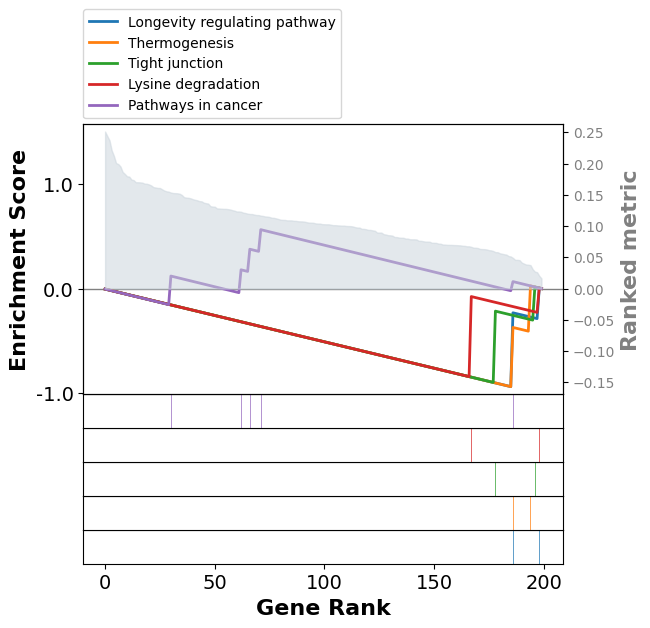

In [14]:
# Run prerank GSEA
pre_res = gp.prerank(
    rnk="lr_ranked_task2.rnk",
    gene_sets='KEGG_2021_Human', 
    outdir='gsea_results',
    min_size=2,
    max_size=100,
    permutation_num=1000,
    seed=6,
    verbose=True
)

# Display top enriched pathways
display(pre_res.res2d.head(5))

# Plot GSEA enrichment for top pathway
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0:5],
                   #legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )